Resources:

* The [Kaggle Course on Deep Learning](https://www.kaggle.com/learn/deep-learning)
* The Coursera Deep Learning specialisation (you can access the course material for free)
* This [Kaggle Kernel](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6). My solution is based on this kernel with a few extras to reduce the error rate even further.

In [1]:
#Imports

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization, Activation
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.losses import categorical_crossentropy

/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

Let's now load the data and have a look.

In [2]:
#Read Data
digit_data = pd.read_csv('../input/train.csv')
digit_data.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The next function preps the data for our model and splits the data into a training set and a validation set.

Each row in our data_set starts with the label followed by 784 integers between 0 and 255 representing the pixel values on a grayscale. In order for CNNs to work appropriately we need to convert each picture to a 28x28 array. We will also scale the pixel values to be between 0 and 1.


In [3]:
img_rows, img_cols = 28,28
num_classes = 10

#Preparing the training data
def data_prep_train(raw,val_frac):
    """
    Prepares the training data for our model
    inputs:
        raw: raw dataset
        val_frac: integer between 0 and 1. Fraction of the data to be used for validation.
    
    Outputs:
        X_train: training examples
        X_val: validation examples
        y_train: training lables
        y_val: validation lables
    """
    num_images = int(raw.shape[0])    
    
    y_full = keras.utils.to_categorical(raw.label, num_classes)
    
    X_as_array = raw.values[:,1:]
    X_shaped_array = X_as_array.reshape(num_images, img_rows, img_cols, 1)
    X_full = X_shaped_array / 255
    
    X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=val_frac)
    return X_train, X_val, y_train, y_val

#Preparing the test data
    """
    Prepares the test data for our model
    inputs:
        raw: raw dataset
    
    Outputs:
        X: test examples
    """
def data_prep_predict(raw):
    num_images = int(raw.shape[0])
    X_as_array = raw.values
    X_shaped_array = X_as_array.reshape(num_images, img_rows, img_cols, 1)
    X = X_shaped_array / 255
    return X

Next, we are going to build our model. The basic structure is Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> Dense -> Dense. For a picture, see below.

The convolutional layers are the basic building block of this model. The Kaggle Course explains nvery nicely how they work. I use the architecture from [this kernel](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6).

The Batch normalization layer scales the input to a certain mean and variance (which are parameters of the model). This seems to give the model a little edge over many other models out there. There is some discussion if this should be done before or after the activation, but I did not notice significant differences.

The goal of the pooling layer is to reduce the complexity of the model whithout loosing too much information. This is explained pretty well in the Coursera Courses.

The standard relu activation works very well. I saw small improvements by using a leaky relu (this function is like relu but has a small slope below 0 to speed up convergence).

The Dropout layer randomly ignores some units with a given probability. This helps the model to avoid overfitting by forcing it not to rely on single units too much.

Finally, we will use a dense layer to make predictions.

In [7]:
def build_model(layer_sizes=[32, 32, 64, 64, 256], kernel_sizes=[5,5,3,3], activation = 'relu'):
    """
    building a CNN with 4+2 layers.
    inputs:
        layer_sizes: list of length 5 containing the number of hidden units in each layer
        kernel_sizes: list of length 4 containing the size of the kernels in the Conv Layers
        activation: The activation function, string or function.
        
    output:
        model: The finished model
    """
    model = Sequential()
    
    model.add(Conv2D(layer_sizes[0], kernel_size=kernel_sizes[0], padding = 'same', input_shape=(img_rows, img_cols, 1)))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Conv2D(layer_sizes[1], kernel_size=kernel_sizes[1], padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(layer_sizes[2], kernel_size=kernel_sizes[2], padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Conv2D(layer_sizes[3], kernel_size=kernel_sizes[3], padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Flatten())
    model.add(Dense(layer_sizes[4]))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

my_model = build_model()
#plot_model(my_model, to_file='my_model.png', show_shapes=True, show_layer_names=True)
#Image('my_model.png')

The key problem of this task is that there is not enough data. We therefore generate new data from our existing data by randomly rotate, zoom and shift the images.
This is explained in all of the ressources I mentioned above. In particular, I use the same settings as in [this kernel](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6).

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,)  # randomly flip images

The following function defines the training process.

By default, we are using the Adam optimizer which is a combination of gradient descent with momentum and RMSProp. See [this video](https://www.youtube.com/watch?v=JXQT_vxqwIs) from a coursera course for a detailed explanation. I tried some other optimizers but achieved the best results with Adam.



In [9]:
def train_model(model, optimizer='adam', batch_size=64, epochs=1, verbose=1, callbacks=[]):
    """
    Trains the model.
    Outputs:
        history: dictionary containing information about the training process like training and validation accuracy
    """
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                            epochs=epochs,
                            verbose=verbose,
                            validation_data=(X_val,y_val),
                            callbacks=callbacks)
    return history

Now, we want to tune the hyperparamters. This process takes quite long as we really need to train for 30-40 epochs to see which model will do best in the end. It is not necessarily the model which converges fastest to a decent accuracy which will give the best results.

In order to have reasonable results, I suggest using at least 20% of the data for validation. This is only for the tuning, later on we will train on almost all of the data to get the most out of it.

It is important to reduce the learning rate in the process in order to keep improving the model. Otherwise, the model tends to jump too far once we are getting close to the minimum. Adam has a parameter 'decay' which does this automatically. I had better results though decreasing the learning_rate whenever the validation accuracy does not improve anymore. This is done with the Keras function ReduceLROnPlateau. I use similar settings as in [this kernel](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6).

I have commented out this section in order to save time.

In [10]:
# leaky_relu = lambda x: relu(x, alpha=0.1)
# X_train, X_val, y_train, y_val = data_prep_train(digit_data,0.2)

# learning_rates = [0,0015,0.003,0.006]

# histories = []
# for lr in learning_rates:
#     optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     lr_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
#     my_model = build_model(activation=leaky_relu)
#     histories.append(train_model(my_model, optimizer=optimizer, epochs=35, batch_size = 64, verbose=2, callbacks=[lr_reduction]))

# colors = ['red', 'blue', 'green', 'purple', 'grey', 'yellow']

# plt.figure(figsize=(20,9))
# for i, lr in enumerate(learning_rates):
#     plt.plot(range(25,36), histories[i].history['val_acc'][24:], color=colors[i],label='learning rate: '+str(lr))
# legend = plt.legend(loc='best', shadow=True)
# plt.show()


Let us train our final model. I am using as much data as possible here, the only reason for the validation set is the learning rate reduction. Therefore, the validation accuracy is very unreliable here and I wouldn't pay too much attention to it.

In [13]:
X_train, X_val, y_train, y_val = data_prep_train(digit_data,0.1)

nr_epochs = 3 # Set to 40 for good results (if you have a GPU)

leaky_relu = lambda x: relu(x, alpha=0.1)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
my_model = build_model(activation=leaky_relu)
history = train_model(my_model, optimizer=optimizer, epochs=nr_epochs, batch_size = 128, verbose=1, callbacks=[lr_reduction])

Epoch 1/3
296/296 [==============================] - 624s 2s/step - loss: 0.3824 - acc: 0.8817 - val_loss: 0.9282 - val_acc: 0.6543
Epoch 2/3
296/296 [==============================] - 693s 2s/step - loss: 0.1202 - acc: 0.9631 - val_loss: 0.0932 - val_acc: 0.9702
Epoch 3/3
296/296 [==============================] - 694s 2s/step - loss: 0.0885 - acc: 0.9736 - val_loss: 0.0530 - val_acc: 0.9850


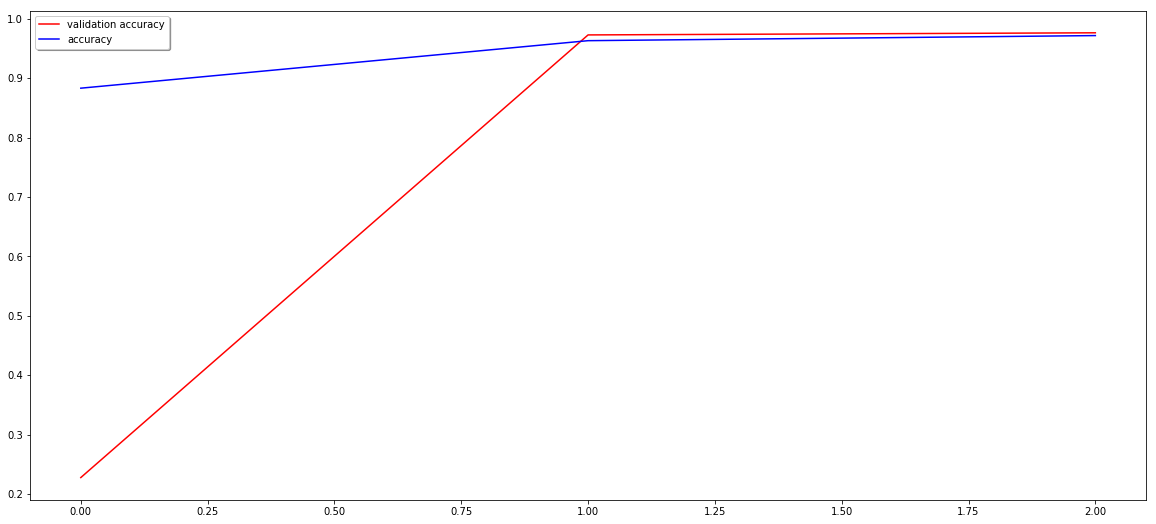

In [12]:
plt.figure(figsize=(20,9))
plt.plot(history.history['val_acc'], color='red', label='validation accuracy')
plt.plot(history.history['acc'], color='blue', label='accuracy')
legend = plt.legend(loc='best', shadow=True)
plt.show()

In [ ]:
#subm_examples = pd.read_csv('../input/test.csv')
#X_subm = data_prep_predict(subm_examples)
#y_subm = my_model.predict(X_subm)
#n_rows = y_subm.shape[0]
#y_subm = [np.argmax(y_subm[row,:]) for row in range(n_rows)]
#output = pd.DataFrame({'ImageId': range(1,n_rows+1), 'Label': y_subm})
#output.to_csv('submission.csv', index=False)